In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats, linalg
import subprocess
import argparse
import json
import sys

In [2]:
def fit_ICA_to_regressors(ica_table, noise_regress_table, polort=4, regress_dict=None, show_plot=False):
    """
    Compute Linear Model and calculate F statistics and P values for combinations of regressors

    Equation: Y = XB + E
    - Y = each ICA component (ica_table)
    - X = Design (Regressor) matrix (subsets of noise_regress_table)
    - B = Weighting Factors (solving for B)
    - E = errors (Y - Y_pred OR Y - XB)

    Input:
        ica_table: A DataFrame with the ICA mixing matrix
        noise_regress_table: A DataFrame with the noise regressor models
        polort: Add polynomial detrending regressors to the linear model
        TestRegress: A Dictionary that groups parts of regressors names in noise_regress_table with common element
           For example, there can be "Motion": {"_dmn", "_drv"} to say take all columns with _dmn and _drv and
           calculate an F value for them together.

    Output: Right now figures, but working on that part

    """

    Y = ica_table.to_numpy()

    print("Running fit_ICA_to_regressors")
    print(f"ICA matrix has {Y.shape[0]} time points and {Y.shape[1]} components")

    
    # Regressor_Models is a dictionary of all the models that will be fit to the ICA data
    #  It will always include 'base' which is just the polort detrending regressors and
    #  'full' which is all relevant regressors including the detrending regressors
    #  For F statistics, the other models need for tests are those that include everything 
    #  EXCEPT the category of interest. For example, there will also be a field for "no Motion"
    #  which contains all regressors in the full model except those that model motion
    Regressor_Models, Full_Model_Labels, regress_dict = build_noise_regressors(noise_regress_table, regress_dict=regress_dict, polort=4, show_plot=show_plot)

    # This is the test for the fit of the full model vs the polort detrending baseline
    # The outputs will be what we use to decide which components to reject
    betas_full, F_vals_tmp, p_vals_tmp, R2_vals_tmp = fit_model_with_stats(Y, Regressor_Models, 'base', show_plot=show_plot)

    betas_full_model = pd.DataFrame(data=betas_full.T, columns=np.array(Full_Model_Labels))
    F_vals = pd.DataFrame(data=F_vals_tmp, columns=['Full Model'])
    p_vals = pd.DataFrame(data=p_vals_tmp, columns=['Full Model'])
    R2_vals = pd.DataFrame(data=R2_vals_tmp, columns=['Full Model'])

    # Test all the fits between the full model and the full model excluding one category of regressor
    for reg_cat in regress_dict.keys():
        _, F_vals_tmp, p_vals_tmp, R2_vals_tmp = fit_model_with_stats(Y, Regressor_Models, f"no {reg_cat}", show_plot=show_plot)
        F_vals[f'{reg_cat} Model'] = F_vals_tmp
        p_vals[f'{reg_cat} Model'] = p_vals_tmp
        R2_vals[f'{reg_cat} Model'] = R2_vals_tmp

    return betas_full_model, F_vals, p_vals, R2_vals

def make_detrend_regressors(n_time, polort=4, show_plot=False):
    """ 
    create polynomial detrending regressors:
       x^0, x^1, x^2, ...

    Inputs:
    n_time: (int) number of time points
    polort: (int) number of polynomial regressors
    show_plot: (bool) If True, will create a plot showing he regressors

    Outputs:
    detrend_regressors: (n_time,polort) np.array with the regressors.
        x^0 = 1. All other regressors are zscore so that they have
        a mean of 0 and a stdev of 1.
    """
    # create polynomial detrending regressors
    detrend_regressors = np.zeros((n_time, polort))
    for idx in range(polort):
        tmp = np.linspace(-1, 1, num=n_time)**idx
        if idx > 0:
            detrend_regressors[:,idx] = stats.zscore(tmp)
            detrend_labels.append(f"polort{idx}")
        else:
            detrend_regressors[:,idx] = tmp
            detrend_labels = ["polort0"]
    if show_plot:
        plt.plot(detrend_regressors)
        plt.show()

    return detrend_regressors, detrend_labels
        

def build_noise_regressors(noise_regress_table, regress_dict=None, polort=4, show_plot=False):
    """
    INPUTS:
    noise_regress_table: A Dataframe where each column is a regressor containing
       some type of noise we want to model
    regress_dict: Model regressors are group into categories to test.
       The keys in this dictionary are the category names (i.e. "Motion").
       The values are unique strings to look for in the column titles in
       noise_regress_table. For example, if all the motion regressors end in
       _dmn or _drv.
       Default:  {"Motion": {"_dmn", "_drv"}, 
                  "Phys_Freq": {"_sin", "_cos"},
                  "Phys_Variability": {"_rvt", "_hrv"},
                  "WM & CSF": {"WM_e", "Csf_vent"}}
    polort: (int) Number of polynomial regressors to include in the baseline noise model. default=4
    show_plot: (bool) Plots each category of regressors, if True. default=False


    """

    print("Running build_noise_regressors")
    # Model regressors are grouped into categories to test
    if regress_dict is None:
        regress_dict = {"Motion": {"_dmn", "_drv"}, 
                        "Phys_Freq": {"_sin", "_cos"},
                        "Phys_Variability": {"_rvt", "_hrv"},
                        "WM & CSF": {"WM_e", "Csf_vent"}}

    # The category titles to group each regressor
    regress_categories = regress_dict.keys()

    # All regressor labels from the data frame
    regressor_labels = noise_regress_table.columns

    # Calculate the polynomial detrending regressors
    detrend_regressors, Full_Model_Labels= make_detrend_regressors(noise_regress_table.shape[0], polort=polort, show_plot=False)


    # Keep track of regressors assigned to each category and make sure none
    #  are assigned to more than one category
    unused_regressor_indices = {i for i in range(len(regressor_labels))}

    categorized_regressors = dict()


    # For each regressor category, go through all the regressor labels
    #   and find the labels that include strings for the category
    #   that should be used
    # Collect the indices for columns to use for each category in tmp_regress_colidx
    for reg_cat in regress_categories:
        tmp_regress_colidx = set()
        for idx, reg_lab in enumerate(regressor_labels):
            for use_lab in regress_dict[reg_cat]:
                if use_lab in reg_lab:
                    tmp_regress_colidx.add(idx)
        tmp = tmp_regress_colidx - unused_regressor_indices
        if len(tmp)>0:
            raise ValueError(f"A regressor column ({tmp}) in {reg_cat} was previous assigned to another category")
        unused_regressor_indices = unused_regressor_indices - tmp_regress_colidx
        # categorized_regressors is a dictionary where a dataframe with just the regressors
        #  for each regressor category are in each element
        categorized_regressors[reg_cat] = noise_regress_table.iloc[:,list(tmp_regress_colidx)]
        print(f"Regressor labels for {reg_cat} are {list(categorized_regressors[reg_cat].columns)}")
        Full_Model_Labels.extend(list(categorized_regressors[reg_cat].columns))


    # Regressor_Models will end up being a dictionary of all the models that will be fit to the ICA data
    #  It starts with 'base' which will just include the polort detrending regressors and
    #  'full' will will be the full model (though just initialized with the detrending regressors)
    Regressor_Models = {'base': detrend_regressors, 'full': detrend_regressors}

    for reg_cat in regress_categories:
        # Add each category of regressors to the full model
        Regressor_Models['full'] = np.concatenate((Regressor_Models['full'], stats.zscore(categorized_regressors[reg_cat].to_numpy(), axis=0)), axis=1)   
        # For F statistics, the other models to test are those that include everything EXCEPT the category of interest
        #  That is "no motion" should contain the full model excluding motion regressors
        nreg_cat = f"no {reg_cat}"
        Regressor_Models[nreg_cat] = detrend_regressors # initialize each model with detrend_regressors
        # Add the categories of regressors excluding reg_cat
        for reg_cat_include in set(regress_categories) - set([reg_cat]):
            Regressor_Models[nreg_cat] = np.concatenate((Regressor_Models[nreg_cat], stats.zscore(categorized_regressors[reg_cat_include].to_numpy(), axis=0)), axis=1)  
        print(f"Size for Regressor Model \'{nreg_cat}\': {Regressor_Models[nreg_cat].shape}")

    print(f"Size for full Regressor Model: {Regressor_Models['full'].shape}")
    print(f"Size for base Regressor Model: {Regressor_Models['base'].shape}")

    if show_plot:
        fig = plt.figure(figsize=(10,10))
        for idx, reg_cat in enumerate(regress_categories):
            if idx<4:
                ax = fig.add_subplot(2,2,idx+1)
                ax.plot(stats.zscore(categorized_regressors[reg_cat].to_numpy(), axis=0))
                plt.title(reg_cat)
        plt.show()

    return Regressor_Models, Full_Model_Labels, regress_dict
            

def fit_model_with_stats(Y, Regressor_Models, base_label, show_plot=False):
    """
    fit_model_with_stats

    Math from page 11-14 of https://afni.nimh.nih.gov/pub/dist/doc/manual/3dDeconvolve.pdf

    Calculates Y=betas*X + error for the base and the full model
    F = ((SSE_base-SSE_full)/(DF_base-DF_full)) /
                 (SSE_full/DF_full)
    DF = degrees of freedom
    SSE = sum of squares error

    Inputs:
    Y (time, components) numpy array
    X_full (time, regressors) numpy array for full model
    X_base (time, regressors) numpy array for base (null) model

    Returns:
    betas_full: The beta fits for the full model (components, regressors) numpy array
    F_vals: The F statistics for the full vs base model fit to each component (components) numpy array
    p_vals: The p values for the full vs base model fit to each component (components) numpy array
    R2_vals: The R^2 values for the full vs base model fit to each component (components) numpy array
    """

    betas_base, SSE_base, DF_base = fit_model(Regressor_Models[base_label],Y)
    betas_full, SSE_full, DF_full = fit_model(Regressor_Models['full'],Y)

    F_vals = np.divide((SSE_base-SSE_full)/(DF_base-DF_full), (SSE_full/DF_full))
    p_vals = 1-stats.f.cdf(F_vals, DF_base-DF_full, DF_full)
    R2_vals = 1 - np.divide(SSE_full,SSE_base)

    # Plots the fits for the first 20 components
    if show_plot:
        fig = plt.figure(figsize=(20,20))
        for idx in range(20):
            
            if idx<=Y.shape[1]:
                ax = fig.add_subplot(5,4,idx+1)
                plot_fit(ax, Y[:,idx], betas_full[:,idx], Regressor_Models['full'], betas_base=betas_base[:,idx], X_base=Regressor_Models[base_label],
                            F_val=F_vals[idx], p_val=p_vals[idx], R2_val=R2_vals[idx], SSE_base=SSE_base[idx], 
                            SSE_full=SSE_full[idx], base_legend=base_label)
    return betas_full, F_vals, p_vals, R2_vals

def fit_model(X, Y):
    """
    Inputs: Y = betas*X + error
       Y is a (time, components) numpy array
       X is a (time, regressors) numpy array

    Outputs:
        betas: The fits in a (components, regressors) numpy array
        SSE: The sum of squared error for the fit
        DF: Degrees of freedom (timepoints - number of regressors)

    """
    betas, _, _, _ = linalg.lstsq(X, Y)
    fit = np.matmul(X, betas)
    SSE = np.sum(np.square(Y-fit), axis=0)
    DF = Y.shape[0] - betas.shape[0]
    return betas, SSE, DF

def plot_fit(ax, Y, betas_full, X_full, betas_base=None, X_base=None, F_val=None, p_val=None, R2_val=None, SSE_base=None, SSE_full=None, base_legend="base fit"):
    """
    plot_fit: Plot the component time series and the fits to the full and base models
    TODO Add if clauses to be able to print out just the mail plot without the base plot
    """

    ax.plot(Y, color='black')
    ax.plot(np.matmul(X_full, betas_full.T), color='red')
    #if (betas_base != None) and (X_base != None):
    ax.plot(np.matmul(X_base, betas_base.T), color='green')
    ax.text(250,2, f"F={np.around(F_val, decimals=4)}\np={np.around(p_val, decimals=4)}\nR2={np.around(R2_val, decimals=4)}\nSSE_base={np.around(SSE_base, decimals=4)}\nSSE_full={np.around(SSE_full, decimals=4)}")
    ax.legend(['ICA Component', 'Full fit', f"{base_legend} fit"], loc='best')


In [26]:
# Load file locations for test file
# Currently works on my laptop with drives mounted to biowulf.
regressors="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/sub-01_RegressorModels_wnw_run-1.tsv"
ica_mixing="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/afniproc_orig/WNW/sub-01.results/tedana_kic_r01/ica_mixing.tsv"
ica_metrics="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/afniproc_orig/WNW/sub-01.results/tedana_kic_r01/ica_metrics.tsv"
prefix="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/tmp/testfits"
os.chdir("/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/tmp")

In [27]:
# Read in the ICA components
ica_table = pd.read_csv(ica_mixing, sep='\t')
print("Size of ICA mixing matrix: ", ica_table.shape)

ica_metrics = pd.read_csv(ica_metrics, sep='\t')
print("Size of ICA metrics table: ", ica_metrics.shape)

# X-Data #
# Read in the Noise Regressors          (24 noise regressors + intercept ts), len = 25
noise_regress_table = pd.read_csv(regressors, sep='\t')
print(f"Size of noise regressors: {noise_regress_table.shape}")

Size of ICA mixing matrix:  (340, 57)
Size of ICA metrics table:  (57, 18)
Size of noise regressors: (340, 26)


Running fit_ICA_to_regressors
ICA matrix has 340 time points and 57 components
Running build_noise_regressors
Regressor labels for Motion are ['roll_dmn', 'pitch_dmn', 'yaw_dmn', 'dS_dmn', 'dL_dmn', 'dP_dmn', 'roll_drv', 'pitch_drv', 'yaw_drv', 'dS_drv', 'dL_drv', 'dP_drv']
Regressor labels for Phys_Freq are ['cardiac_sin1', 'cardiac_cos1', 'cardiac_sin2', 'cardiac_cos2', 'resp_sin1', 'resp_cos1', 'resp_sin2', 'resp_cos2']
Regressor labels for Phys_Variability are ['ecg_hrv', 'resp_rvt']
Regressor labels for WM & CSF are ['WM_e', 'Csf_vent']
Size for Regressor Model 'no Motion': (340, 16)
Size for Regressor Model 'no Phys_Freq': (340, 20)
Size for Regressor Model 'no Phys_Variability': (340, 26)
Size for Regressor Model 'no WM & CSF': (340, 26)
Size for full Regressor Model: (340, 28)
Size for base Regressor Model: (340, 4)


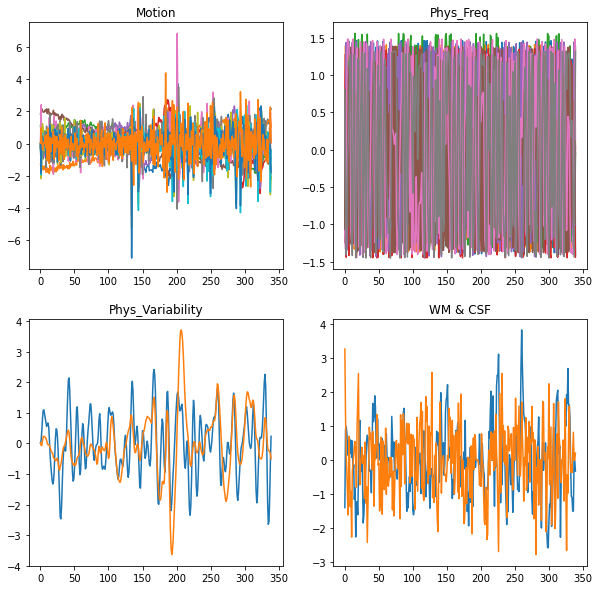

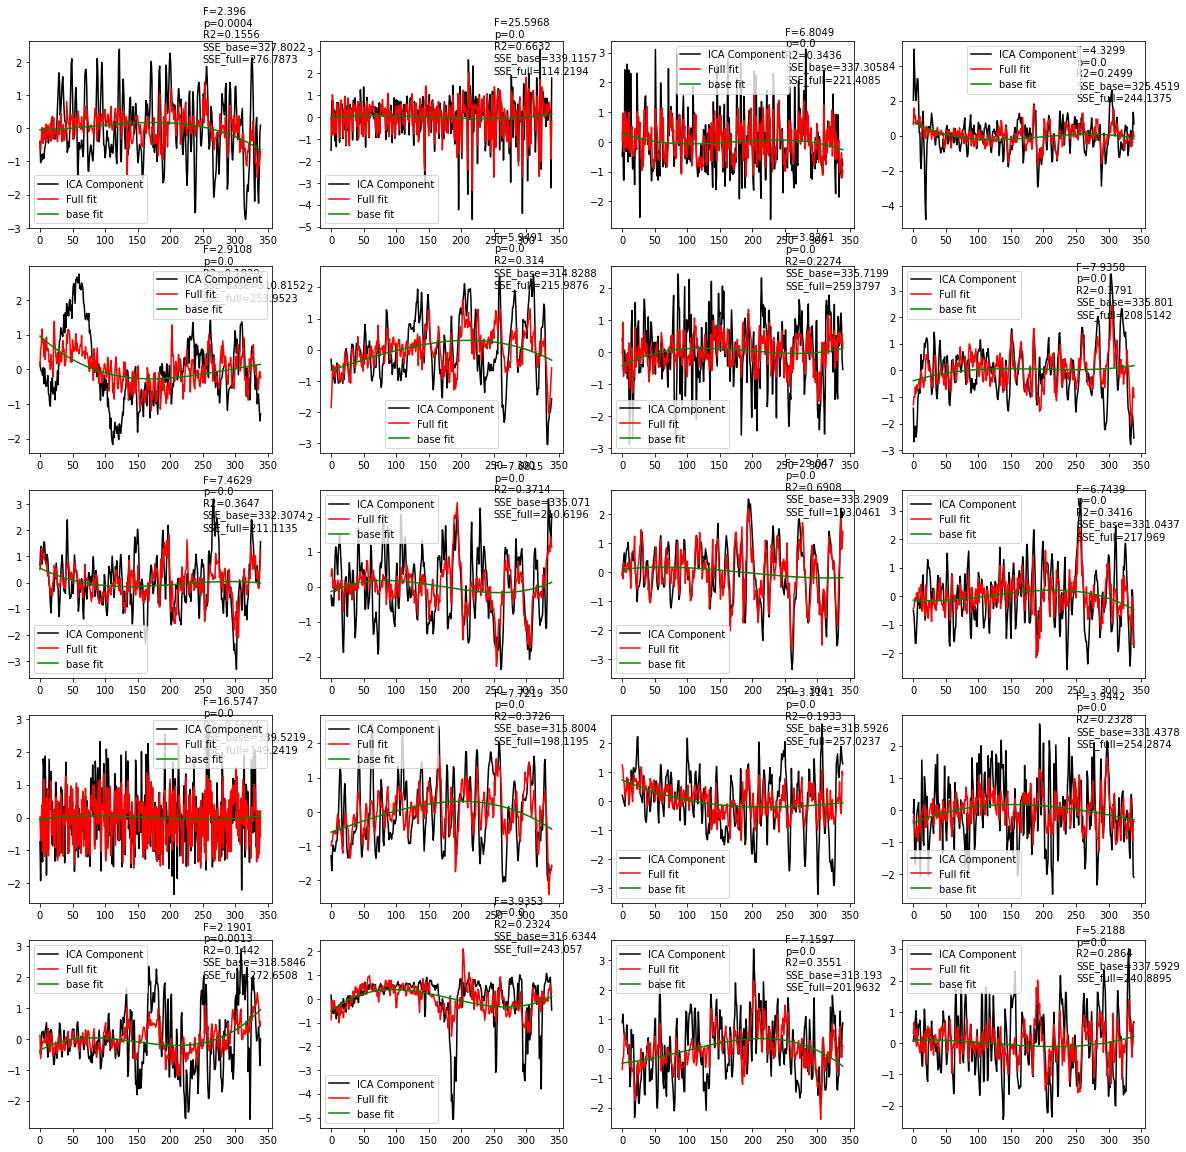

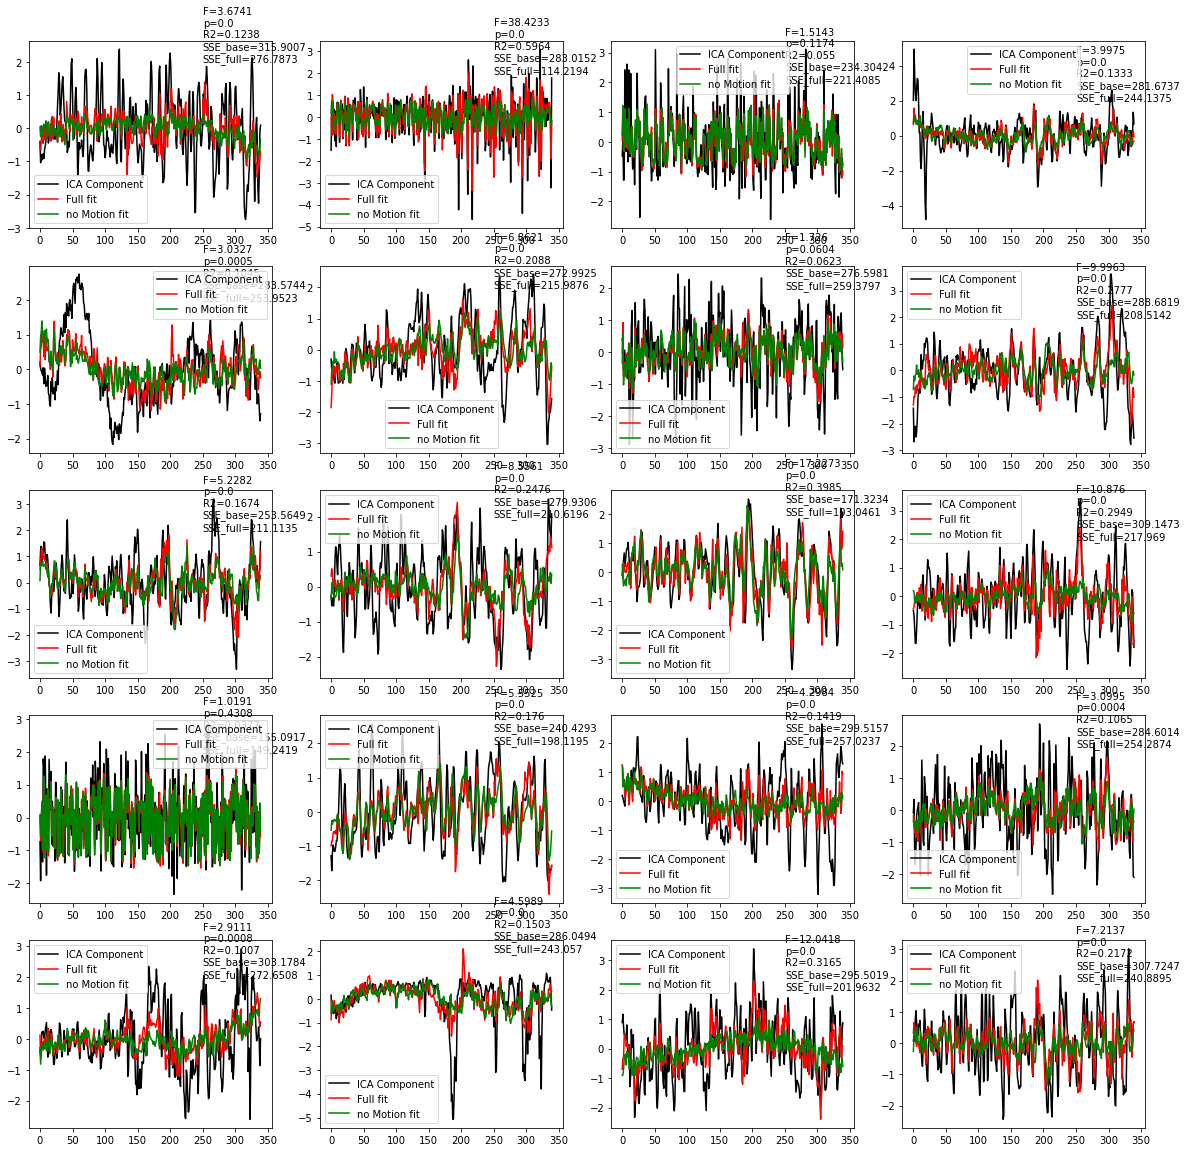

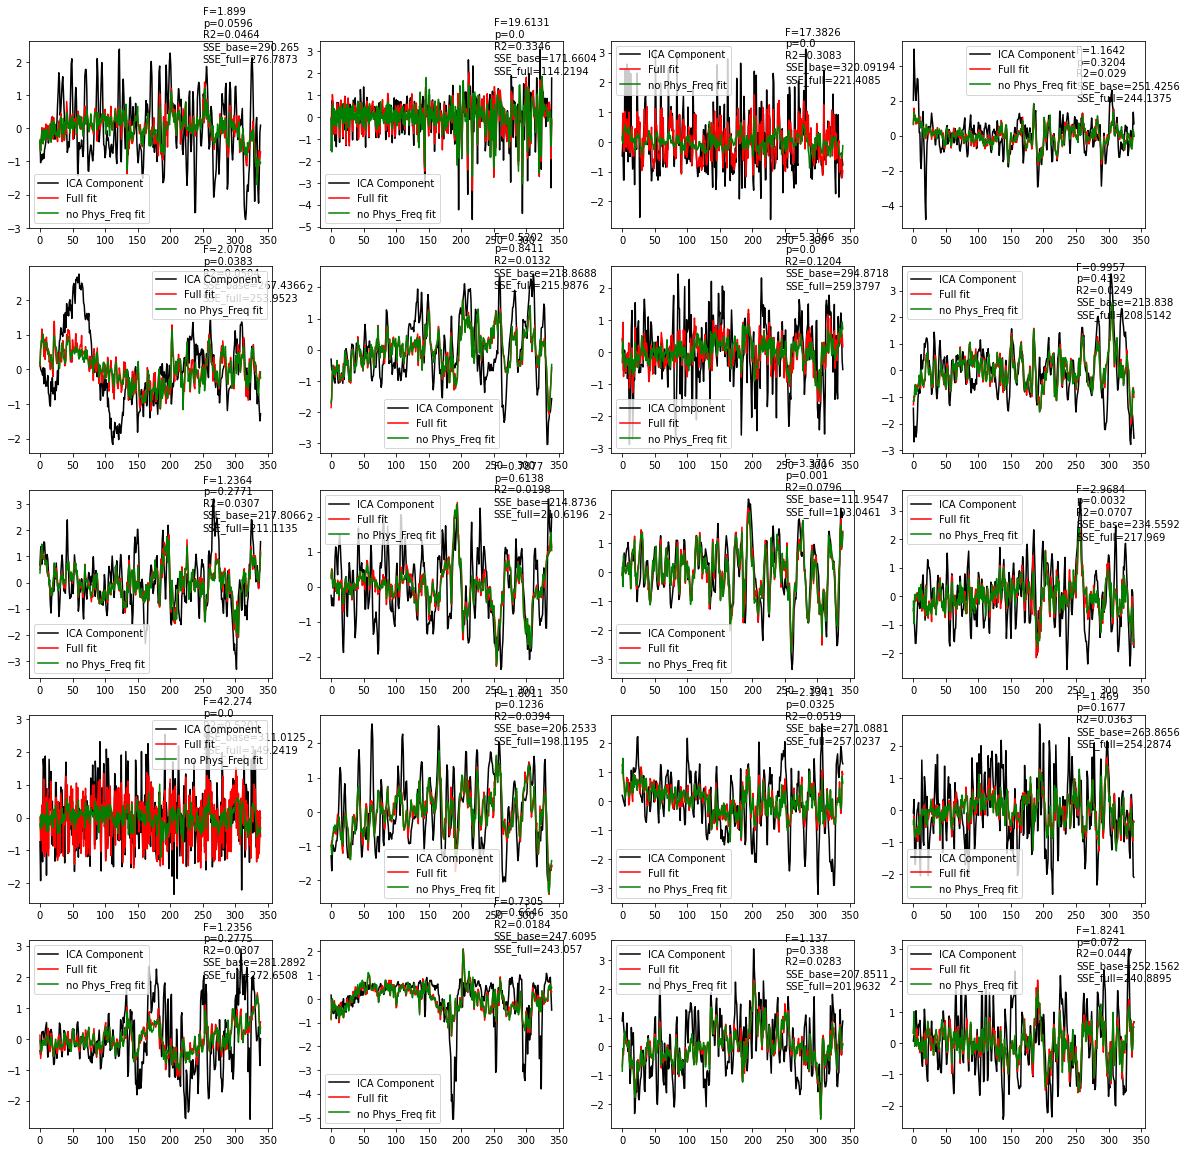

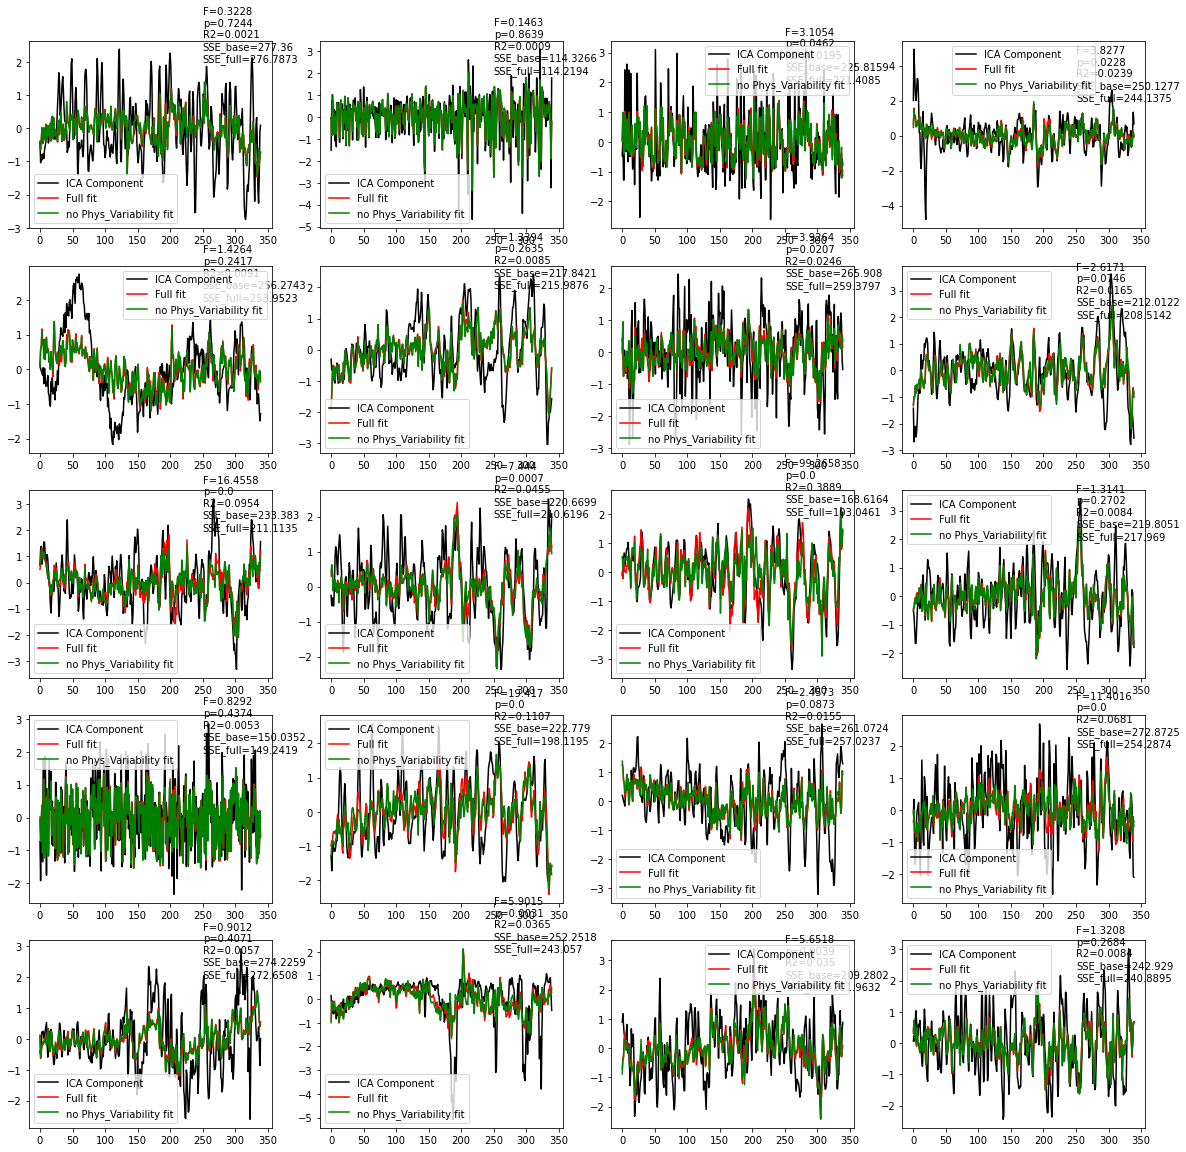

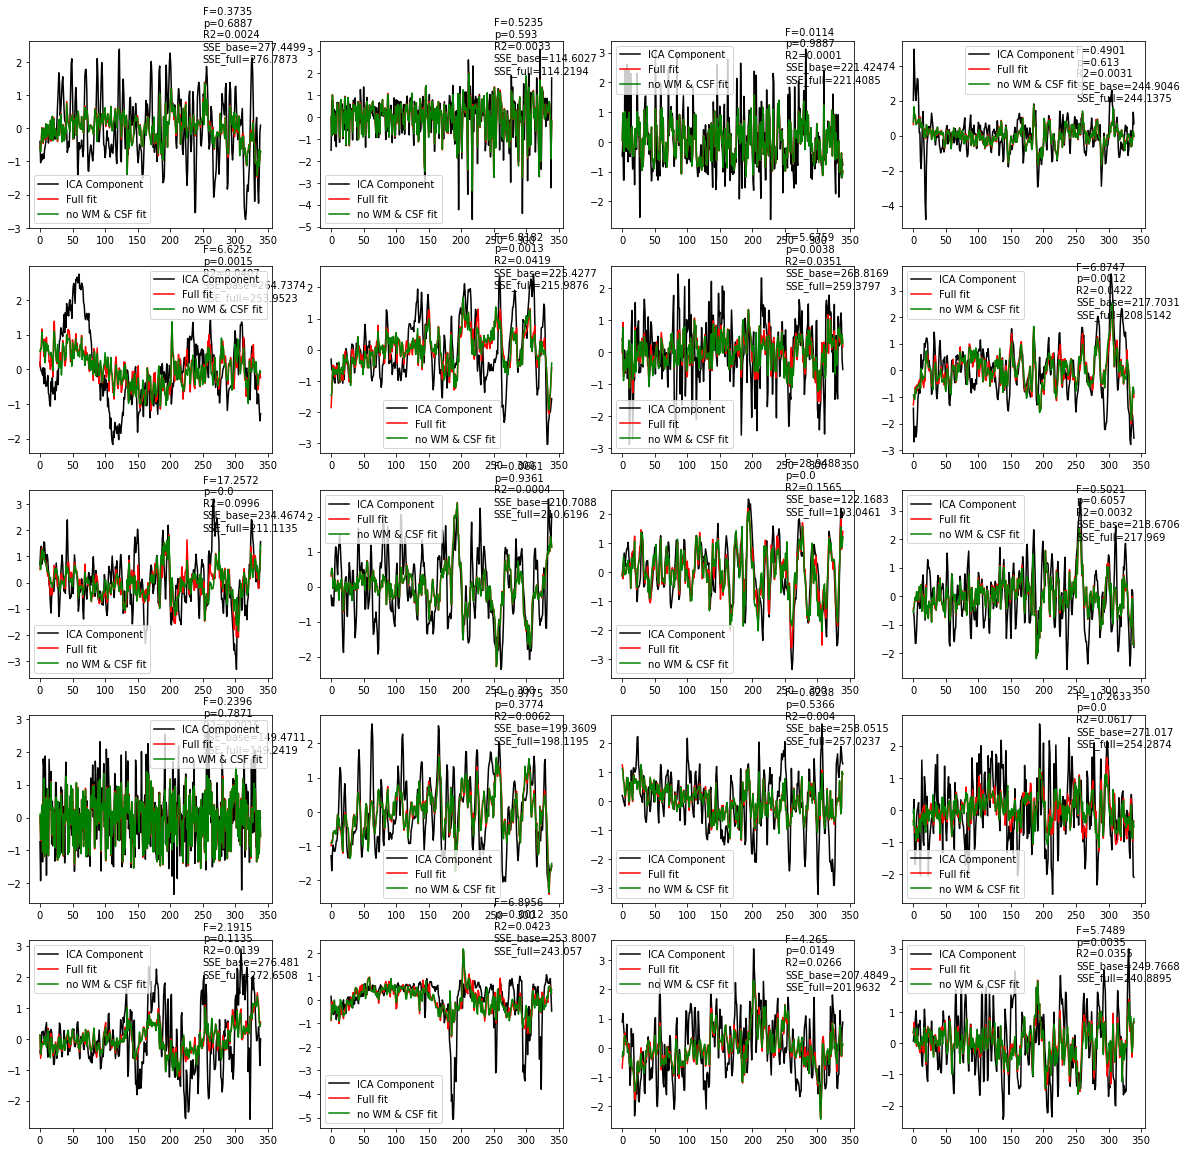

In [6]:
# Run the fits and see the plotted results

# Fit the models and calculate signficance
betas_full_model, F_vals, p_vals, R2_vals = fit_ICA_to_regressors(ica_table, noise_regress_table, show_plot=True)
# In the output below, the first series of subplots is the full model vs the baseline of the polort detrending regressors for the first 20 components
# The following series of suplots are the full model vs the full model excluding other categories of regressors
# (which shows the significanc of each category of regressors)
# One thing I'm noticing is that a lot of these seem significant. To be conservative, we might want to set agressive thresholds or only reject
#   components with a significantly low p AND a R2 that high enough to show that the noise regressors account for a substantial amount of
#   the variance in the ICA component

In [70]:
# betas_full_model, F_vals, p_vals, R2_vals
# F_vals

rootdir = "~/tmp/LMtest"
prefix = "TestOut"
justprefix = os.path.basename(prefix)
outdir = os.path.join(rootdir, os.path.dirname(justprefix))

p_thresh = 0.05 # Find fits of p<p_thresh with Bonferroni correction for the number of components
R2_thresh = 0.5 # Threshold for components where the R2>R2_thresh (i.e. not just significant, but models a non-trivial amount of variance)

num_components = len(ica_table.columns)
p_thresh_Bonf = p_thresh/num_components

Reject_Components = np.logical_and((p_vals['Full Model']<p_thresh_Bonf).values, (R2_vals['Full Model']>R2_thresh).values)
num_reject = Reject_Components.sum()
print(f"Rejecting {num_reject} of {num_components} components using regressors")

reject_idx = np.squeeze(np.argwhere(Reject_Components))


# print(type(Reject_Components))
# print(reject_idx)

# print(Rejected_Component_Timeseries)

if type(ica_metrics) != "NoneType":
    # ica_metrics.loc[ica_metrics['classification']=='rejected', 'Component']
    tedana_reject_idx = np.squeeze(np.argwhere((ica_metrics['classification']=='rejected').values))
    reject_just_regressors = list(set(reject_idx)-set(tedana_reject_idx))
    reject_just_tedana = list(set(tedana_reject_idx) - set(reject_idx))
    reject_idx = list(set(reject_idx).union(set(tedana_reject_idx)))
    print(f"Rejecting {len(tedana_reject_idx)} of {num_components} components using tedana")
    print(f"Components rejected by both {reject_idx}")
    print(f"Components rejected by just tedana {reject_just_tedana}")
    print(f"Components rejected by just regressors {reject_just_regressors}")
    num_reject = len(reject_idx)
    print(f"Rejecting {num_reject} of {num_components} components using regressors and tedana")

Rejected_Component_Timeseries = ica_table.iloc[:,reject_idx]

F_vals.to_csv(f"{outdir}/{justprefix}_Fvals.csv")
p_vals.to_csv(f"{outdir}/{justprefix}_pvals.csv")
R2_vals.to_csv(f"{outdir}/{justprefix}_R2vals.csv")
betas_full_model.to_csv(f"{outdir}/{justprefix}_betas.csv")
Rejected_Component_Timeseries.to_csv(f"{outdir}/{justprefix}_Rejected_ICA_Components.csv", index=False)

# TODO Get all these printed outputs into a file that can be compared across runs
# TODO Thresholds should for rejecting regressors should be command line inputs
# TODO Think of something to call the regressors besides "regressorss"


Rejecting 15 of 57 components using regressors
Rejecting 26 of 57 components using tedana
Components rejected by both [1, 2, 6, 10, 12, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 29, 30, 36, 38, 41, 45, 46, 47, 48, 49, 53, 55]
Components rejected by just tedana [2, 6, 45, 15, 16, 17, 18, 47, 49, 22, 55, 24, 29]
Components rejected by just regressors [25, 21]
Rejecting 28 of 57 components using regressors and tedana


In [ ]:
# NOT CURRENTLY USING, BUT NEED TO USE TO PUT EVERYTHING BACK TOGETHER
def main():
    """
    Implements multiple linear modeling & multivariate modeling

    Inputs (multiple):
    Regressor pandas dataframe:
    6 motion params (demeaned), 1st derivatives of 6 motion parameters (deriv), 
    2 cardiac RETROICOR regressors, 2 resp RETROICOR regressors,
    1 HRV regressor, 1 RVT regressor

    Output (1):
    ICA component

    Linear Model:
    Y = MX + e
    Y = fit to ICA component time series (CxT) -> 1 dependent variable (prediction of fit to Y-variable)
    M = coefficient matrix you’re solving for (CxN) -> 
    X = all the above regressors and a row of ones for the intercept) (NxT) -> multiple independent variables
    e = error

    equation:  y = A+B1x1+B2x2+B3x3+B4x4

    C=# of components
    T=Time
    N=number of nuisance regressors
    """

    """
    sub=sub-01
    task=wnw
    run=1

    Parser call:
    python3 /Users/holnessmn/Desktop/BIDS_conversions/Linear_Model.py \
    --regressors /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/${sub}_RegressorModels_${task}_run-${run}.tsv \
    --ica_mixing /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/ica_mixing.tsv \
    --prefix /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/${sub}_LinearModel_${task}_run-${run}

    """


# rootdir = "~/tmp/LMtest"
# prefix = "TestOut"
# justprefix = os.path.basename(prefix)
# outdir = os.path.join(rootdir, os.path.dirname(justprefix))
# tedana comp table (optional)

    parser = argparse.ArgumentParser()
    parser.add_argument("--rootdir", dest="rootdir", help="Root directory for where to read and write files", type=str default='./')
    parser.add_argument("--regressors", dest="regressors", help="Regressor Model file", type=str)
    parser.add_argument("--ica_mixing", dest="ica_mixing", help="ICA mixing matrix", type=str)
    parser.add_argument("--prefix", dest="prefix", help="File Prefix & redirected output", type=str)

    ARG = parser.parse_args()


    if ARG.regressors and os.path.isfile(ARG.regressors):
        regress = ARG.regressors
    else:
        raise Exception(f"This file/filepath {ARG.regressors} does not exist!!!")

    if ARG.ica_mixing and os.path.isfile(ARG.ica_mixing):
        ica = ARG.ica_mixing
    else:
        raise Exception(f"This file/filepath {ARG.ica_mixing} does not exist!!!")

    if ARG.prefix and type(ARG.prefix) == str:
        prefix = ARG.prefix
    else:
        raise Exception(f"Not a string {ARG.prefix} !!!")


    # General question: How does each X-regressor (noise model) match each Y-comp (ICA component ts)?

    # Y-Data #
    # Read in the ICA components
    ica_table = pd.read_csv(ica, sep='\t')
    # ['ICA_00','ICA_01',...]
    # ica_tsv.columns
    # multi-dimensional list with each component timeseries as sub-list, len = Num of timesteps/volumes
    # icamix = ica_tsv.to_numpy()
    #icamixlist = [ica_tsv[i] for i in ica_tsv.columns]     

    print("Size of ICA mixing matrix: ", ica_table.shape)

    # X-Data #
    # Read in the Noise Regressors          (24 noise regressors + intercept ts), len = 25
    noise_regress_table = pd.read_csv(regress, sep='\t')
    # Regressor models ['cardiac_sin1','cardiac_cos1',...'WM_e','Csf_vent']
    # regres_tsv.columns
    # multi-dimensional list with each regressor timeseries as sub-list, len = Num of timesteps/volumes (indexed by TRs...)
    # noise_regress = regres_tsv.to_numpy()

    print(f"Size of noise regressors: {noise_regress_table.shape}")

    #visual_check(icamixlist, nphlmlist)
    
    TestRegress = ["_dmn", "_drv", {"_sin", "_cos"}, {"_rvt", "_hrv"}, {"WM_e", "Csf_vent"}]
    # Fit the models and calculate signficance
    coefficient_matrix, R_sq, pvals = linear_model(ica_table, noise_regress_table, polort=True, TestRegress=TestRegress)
    
    

    convert(coefficient_matrix, R_sq, pvals, prefix)
    significant_ICs()


In [ ]:
print(set(regress_categories))
print(set([reg_cat]))